In [2]:
import mellon
import pickle
import scanpy as sc
import magic
import seaborn as sns
import networkx as nx
import oslom
from argparse import Namespace
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d.art3d import LineCollection
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import NearestNeighbors


def sanitize_types_for_h5(adata):
    adata.var=adata.var.convert_dtypes()
    adata.obs=adata.obs.convert_dtypes()

    for c,t in zip(adata.obs.columns,adata.obs.dtypes):
        adata.obs[c]=adata.obs[c].to_list()
        if t == object:
            print(c,t)
            adata.obs[c]=pd.to_numeric(adata.obs[c], errors='coerce')

    for c,t in zip(adata.var.columns,adata.var.dtypes):
        adata.var[c]=adata.var[c].to_list()
        if t == object:
            print(c,t)
            adata.var[c]=pd.to_numeric(adata.var[c], errors='coerce')
    
    if adata.raw is not None:
        adata.raw.var.columns = adata.raw.var.columns.astype(str)
        for c,t in zip(adata.raw.var.columns,adata.raw.var.dtypes):
            adata.raw.var[c]=adata.raw.var[c].to_list()
            if t == object:
                adata.var[c]=pd.to_numeric(adata.raw.var[c], errors='coerce')
    
    adata.obs=adata.obs.fillna(np.nan)
    adata.var=adata.var.fillna(np.nan)
    adata.var.columns = adata.var.columns.astype(str)
    adata.obs.columns = adata.obs.columns.astype(str)
    return(adata)

def ismember(a, b):
    bind = {}
    for i, elt in enumerate(b):
        if elt not in bind:
            bind[elt] = i
    result = [bind.get(itm, None) for itm in a]  # None can be replaced by any other "not in b" value
    result = [result, [not x is None for x in result]]
    return result

def norm_log_transform(adata_local, size_factors, cell_filter):
    if(len(cell_filter) > 0):
        adata_local = adata_local[cell_filter,:].copy()
        size_factors = np.array(size_factors)[cell_filter]
    else:
        adata_local = adata_local.copy()
    print("Normalizing data")
    if(scipy.sparse.issparse(adata_local.X)):
        c = scipy.sparse.diags(1/size_factors)
        adata_local.X = c * adata_local.X * np.median(size_factors)
    else:
        adata_local.X = adata_local.X / size_factors[:,None] * np.median(size_factors)
    
    print("Log transform with pseudocount 1")
    sc.pp.log1p(adata_local)
    return(adata_local)


## Pre-processing of scRNA-seq dataset (Filtering and re-annotation)

In [72]:
genes = pd.read_table('GSE141259_HighResolution_genes.txt', header = None)
cells = pd.read_table('GSE141259_HighResolution_barcodes.txt', header = None)
info = pd.read_table('GSE141259_HighResolution_cellinfo.csv')

In [15]:
adata = sc.read_mtx('GSE141259_HighResolution_rawcounts.mtx')

In [19]:
adata.obs_names =  cells[0]
adata.var_names =  genes[0]
adata.obs = info
adata.obsm['X_umap'] = adata.obs[['umap_1', 'umap_2']].values

In [116]:
adata.obs['time_point'] = adata.obs['time_point'].astype('str')
adata.obs.loc[adata.obs['time_point'] == 'd14_PBS', 'time_point'] = 'Control'

from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=['Control', 'day 2', 'day 3', 'day 4', 'day 5',
                                        'day 6', 'day 7', 'day 8', 'day 9', 'day 10', 'day 11', 'day 12',
                                        'day 13', 'day 15', 'day 21','day 28', 'day 36', 'day 54'], ordered=True)
adata.obs['time_point'] = adata.obs['time_point'].astype(cat_type)

In [2]:
from scipy.sparse import csr_matrix, find, issparse
from scipy.sparse.linalg import eigs

def getDiffusionComponents(adata_de_master, knn=30, n_components = 10):
    adata_de_temp = adata_de_master.copy()
    sc.pp.neighbors(adata_de_temp, n_neighbors=knn)
    
    if(issparse(adata_de_temp.X)):
        my_matrix = adata_de_temp.X.todense().copy()
    else:
        my_matrix = adata_de_temp.X.copy()

    data_df = pd.DataFrame(my_matrix, index = adata_de_temp.obs_names, columns = adata_de_temp.var_names)
    N = data_df.shape[0]
    kNN = adata_de_temp.obsp["distances"]
    adaptive_k = int(np.floor(knn / 3))
    adaptive_std = np.zeros(N)

    for i in np.arange(len(adaptive_std)):
        adaptive_std[i] = np.sort(kNN.data[kNN.indptr[i] : kNN.indptr[i + 1]])[
            adaptive_k - 1
        ]

    # Kernel
    x, y, dists = find(kNN)

    # X, y specific stds
    dists = dists / adaptive_std[x]
    W = csr_matrix((np.exp(-dists), (x, y)), shape=[N, N])

    # Diffusion components
    kernel = W + W.T

    # Markov
    D = np.ravel(kernel.sum(axis=1))

    D[D != 0] = 1 / D[D != 0]
    T = csr_matrix((D, (range(N), range(N))), shape=[N, N]).dot(kernel)
    # Eigen value dcomposition
    D, V = eigs(T, n_components, tol=1e-4, maxiter=1000)
    D = np.real(D)
    V = np.real(V)
    inds = np.argsort(D)[::-1]
    D = D[inds]
    V = V[:, inds]

    # Normalize
    for i in range(V.shape[1]):
        V[:, i] = V[:, i] / np.linalg.norm(V[:, i])

    # Create are results dictionary
    res = {"T": T, "EigenVectors": V, "EigenValues": D}
    res["EigenVectors"] = pd.DataFrame(res["EigenVectors"])
    if not issparse(data_df):
        res["EigenVectors"].index = data_df.index
    res["EigenValues"] = pd.Series(res["EigenValues"])
    res["kernel"] = kernel
    return(res)

def imputeData(adata_de_master, T, n_steps = 1):
    if(issparse(adata_de_master.X)):
        my_matrix = adata_de_master.X.todense().copy()
    else:
        my_matrix = adata_de_master.X.copy()

    data_df = pd.DataFrame(my_matrix, index = adata_de_master.obs_names, columns = adata_de_master.var_names)
    T_steps = T ** n_steps
    
    imputed_data = pd.DataFrame(
        np.dot(T_steps.todense(), data_df), index=data_df.index, columns=data_df.columns
    )
    return(imputed_data)

def plot_diffusion_components(tsne, DCs, vmax=None):
    """ Plots the diffusion components on tSNE maps
    :return: fig, ax
    """

    # Please run tSNE before plotting diffusion components. #
    # Please run diffusion maps using run_diffusion_map before plotting #

    # Plot
    fig = FigureGrid(DCs.shape[1], 5)

    for i, ax in enumerate(fig):
        ax.scatter(
            tsne[:,0],
            tsne[:,1],
            c=DCs[:, i],
            #cmap = 'Reds',
            cmap=matplotlib.cm.Spectral_r,
            edgecolors="none",
            s=3,
        )
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())
        ax.set_aspect("equal")
        ax.set_title("Component %d" % i, fontsize=10)
        ax.set_axis_off()

class FigureGrid:
    """
    Generates a grid of axes for plotting
    axes can be iterated over or selected by number. e.g.:
    >>> # iterate over axes and plot some nonsense
    >>> fig = FigureGrid(4, max_cols=2)
    >>> for i, ax in enumerate(fig):
    >>>     plt.plot(np.arange(10) * i)
    >>> # select axis using indexing
    >>> ax3 = fig[3]
    >>> ax3.set_title("I'm axis 3")
    """

    # Figure Grid is favorable for displaying multiple graphs side by side.

    def __init__(self, n: int, max_cols=3, scale=3):
        """
        :param n: number of axes to generate
        :param max_cols: maximum number of axes in a given row
        """

        self.n = n
        self.nrows = int(np.ceil(n / max_cols))
        self.ncols = int(min((max_cols, n)))
        figsize = self.ncols * scale, self.nrows * scale

        # create figure
        self.gs = plt.GridSpec(nrows=self.nrows, ncols=self.ncols)
        self.figure = plt.figure(figsize=figsize)

        # create axes
        self.axes = {}
        for i in range(n):
            row = int(i // self.ncols)
            col = int(i % self.ncols)
            self.axes[i] = plt.subplot(self.gs[row, col])

    def __getitem__(self, item):
        return self.axes[item]

    def __iter__(self):
        for i in range(self.n):
            yield self[i]

In [7]:
dm_res = getDiffusionComponents(adata)
imputed_X = imputeData(adata, T = dm_res['T'])
kernel_key = "DM_Kernel"
sim_key = "DM_Similarity"
eigval_key = "DM_EigenValues"
eigvec_key = "DM_EigenVectors"

adata.obsp[kernel_key] = dm_res["kernel"]
adata.obsp[sim_key] = dm_res["T"]
adata.obsm[eigvec_key] = dm_res["EigenVectors"].values
adata.uns[eigval_key] = dm_res["EigenValues"].values

adata.layers['MAGIC_imputed_data'] = imputed_X

         Falling back to preprocessing with `sc.pp.pca` and default params.


d:\Python\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
d:\Python\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
d:\Python\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.ji

In [8]:
#sc.write(filename = 'raw_lung.h5', adata = adata, ext='h5')

## Reading dataset

In [3]:
adata = sc.read_h5ad('raw_lung.h5')

/home/lufesu/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


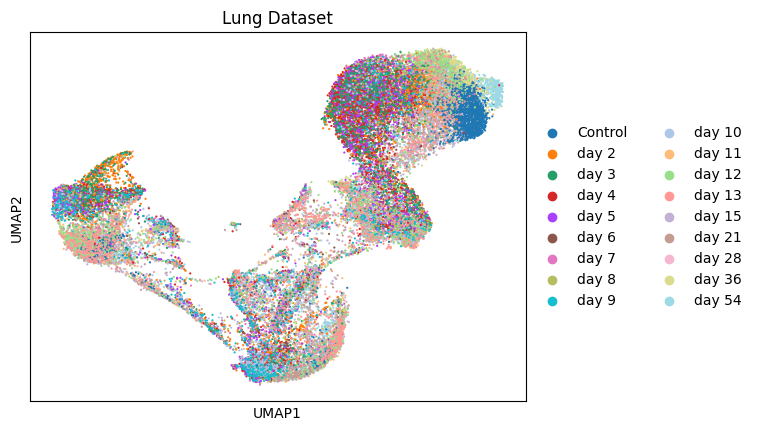

In [4]:
## UMAP colored by time-point

sc.pl.umap(adata, color='time_point', s = 10, add_outline = False, title = 'Lung Dataset')


## Obtaining cell counts from sc-RNA seq dataset

In [5]:
d1 = adata.obs.groupby(['time_point', 'cell_type']).size().to_frame().reset_index()
d1['time_point'] = d1['time_point'].astype(str)
d1.loc[  d1['time_point'] == 'Control', 'time_point' ] = 0
d1.loc[  d1['time_point'] == 'day 2', 'time_point' ] = 2
d1.loc[  d1['time_point'] == 'day 3', 'time_point' ] = 3
d1.loc[  d1['time_point'] == 'day 4', 'time_point' ] = 4
d1.loc[  d1['time_point'] == 'day 5', 'time_point' ] = 5
d1.loc[  d1['time_point'] == 'day 6', 'time_point' ] = 6
d1.loc[  d1['time_point'] == 'day 7', 'time_point' ] = 7
d1.loc[  d1['time_point'] == 'day 8', 'time_point' ] = 8
d1.loc[  d1['time_point'] == 'day 9', 'time_point' ] = 9
d1.loc[  d1['time_point'] == 'day 10', 'time_point' ] = 10
d1.loc[  d1['time_point'] == 'day 11', 'time_point' ] = 11
d1.loc[  d1['time_point'] == 'day 12', 'time_point' ] = 12
d1.loc[  d1['time_point'] == 'day 13', 'time_point' ] = 13
d1.loc[  d1['time_point'] == 'day 15', 'time_point' ] = 15
d1.loc[  d1['time_point'] == 'day 21', 'time_point' ] = 21
d1.loc[  d1['time_point'] == 'day 28', 'time_point' ] = 28
d1.loc[  d1['time_point'] == 'day 36', 'time_point' ] = 36
d1.loc[  d1['time_point'] == 'day 54', 'time_point' ] = 54

d1 = d1.rename(columns = {0 : 'values'})

d1 = d1[~d1['cell_type'].isin(['AT2', 'MHC-II+ Club'])]

d1 = d1[d1['time_point'] < 15]

df_pivot = d1.pivot(index='time_point', columns='cell_type', values='values')

#df_pivot = df_pivot.div(df_pivot.sum(axis = 1), axis = 0)

df_pivot

/tmp/ipykernel_376/2526854561.py:28: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_pivot = d1.pivot(index='time_point', columns='cell_type', values='values')


cell_type,AT1,AT2 activated,Basal,Ciliated,Ciliated activated,Club,Club activated,Club to ciliated,Goblet,Krt8+ ADI,Mki67+ Proliferation,Neuroendocrine
time_point,,,,,,,,,,,,
0,20,3,5,242,18,134,12,43,46,3,24,3
2,2,504,4,47,563,75,215,59,82,80,1,2
3,23,1068,8,33,419,28,153,38,57,143,20,4
4,3,1352,4,29,319,23,259,23,93,217,22,2
5,23,1013,7,26,386,23,244,37,87,219,34,2
6,11,294,1,7,132,16,85,16,37,78,40,3
7,30,417,5,15,229,17,149,24,53,188,63,3
8,50,273,7,38,195,39,106,11,40,192,56,6
9,46,161,12,46,322,53,261,46,119,233,39,4


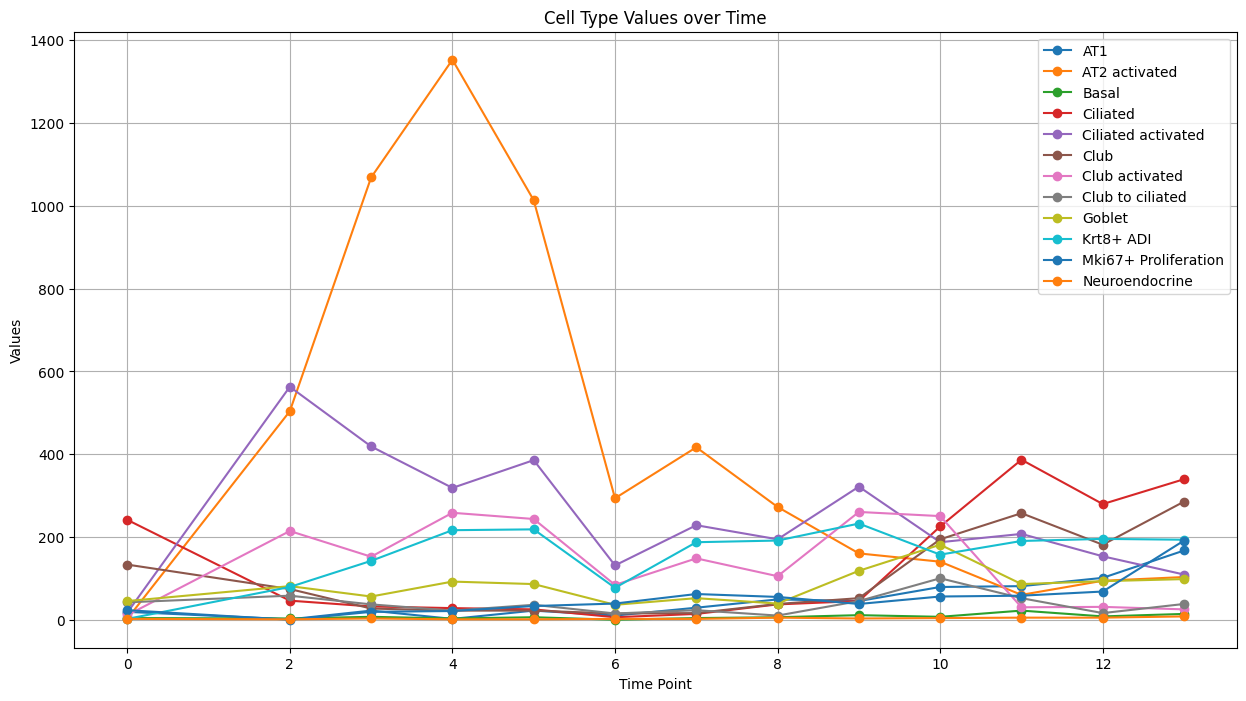

In [6]:
# Plotting
plt.figure(figsize=(15, 8))
for cell_type in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[cell_type], marker='o', label=cell_type)
plt.xlabel('Time Point')
plt.ylabel('Values')
plt.title('Cell Type Values over Time')
plt.legend()
plt.grid(True)
plt.show()    

## Modeling

In [7]:
import numpy as np
import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

num_time_points = 13
num_cell_types = 12

data_matrix = df_pivot.to_numpy()

data = torch.tensor(data_matrix, dtype=torch.float32)

# Model definition
def cell_reg_model(data):
    # Parameters to be learned
    B_0 = pyro.param("B_0", torch.zeros(num_time_points))
    Beta = pyro.param("Beta", torch.zeros((num_time_points, num_cell_types)))
    lambda_ = pyro.param("lambda_", torch.tensor(1.0), constraint=dist.constraints.positive)

    # Trend filtering component
    D1 = np.diff(np.eye(num_time_points), n=1, axis=0)
    smoothness_penalty = lambda_ * torch.norm(torch.matmul(torch.tensor(D1, dtype=torch.float32), Beta), p=1)
    pyro.factor("smoothness_penalty", -smoothness_penalty)

    # Poisson likelihood
    for i in range(num_time_points):
        for k in range(num_cell_types):
            mu_ik = lambda_ * B_0[i] + Beta[i, k]
            pyro.sample(f"obs_{i}_{k}", dist.Poisson(torch.exp(mu_ik)), obs=data[i, k])

# Guide (for SVI)
def guide(data):
    pass  # Using an empty guide as we're learning parameters directly

# SVI setup
svi = SVI(cell_reg_model, guide, Adam({"lr": 0.005}), Trace_ELBO())
n_steps = 10000

# Model fitting
losses = []
for step in range(n_steps):
    loss = svi.step(data)
    losses.append(loss)
    if step % 500 == 0:
        print(f"Step {step}, loss: {loss}")

# Extract learned parameters
learned_B_0 = pyro.param("B_0").detach().numpy()
learned_Beta = pyro.param("Beta").detach().numpy()
learned_lambda = pyro.param("lambda_").item()



Step 0, loss: 85121.72165870667
Step 500, loss: 1044.0939745903015
Step 1000, loss: 722.8089792728424
Step 1500, loss: 699.6283936500549
Step 2000, loss: 686.1712173223495
Step 2500, loss: 674.3331463336945
Step 3000, loss: 662.1924111843109
Step 3500, loss: 649.3711667060852
Step 4000, loss: 636.0051198005676
Step 4500, loss: 622.3628973960876
Step 5000, loss: 608.7175807952881
Step 5500, loss: 595.2526037693024
Step 6000, loss: 582.1319854259491
Step 6500, loss: 569.4003454446793
Step 7000, loss: 557.1383796930313
Step 7500, loss: 545.3361278772354
Step 8000, loss: 533.9884235858917
Step 8500, loss: 523.0540088415146
Step 9000, loss: 512.4619963169098
Step 9500, loss: 502.14862978458405


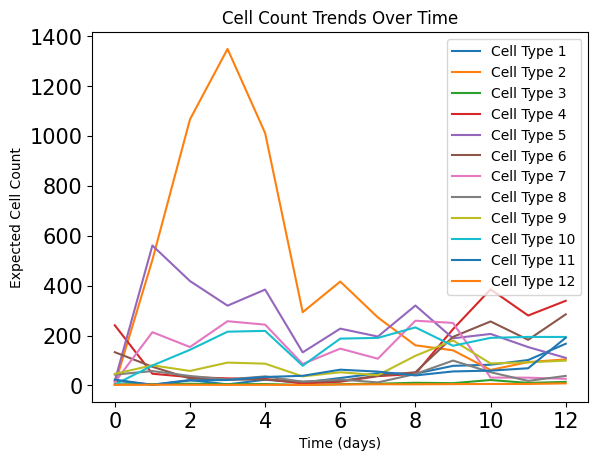

Learned Beta values for each cell type and time point:
[[ 6.4409071e-01 -1.0395916e+00 -8.6692679e-01  3.1657743e+00
   6.0264480e-01  2.5727296e+00  2.1310484e-01  1.4524657e+00
   1.5210994e+00 -1.0395917e+00  8.3170533e-01 -1.4528311e+00]
 [-1.3679800e+00  3.6932042e+00 -9.0098995e-01  1.3204030e+00
   3.8017397e+00  1.7880141e+00  2.8356938e+00  1.5255055e+00
   1.8622563e+00  1.8525782e+00 -1.7418138e+00 -1.4538542e+00]
 [ 6.4169079e-01  4.5353727e+00 -5.4153889e-01  1.0724884e+00
   3.5998187e+00  8.9300573e-01  2.6002541e+00  1.1987574e+00
   1.6255311e+00  2.5247538e+00  5.5598670e-01 -1.4485356e+00]
 [-8.3947319e-01  4.9371209e+00 -6.4823890e-01  1.0729668e+00
   3.4977992e+00  8.5987514e-01  3.2809496e+00  9.1412610e-01
   2.2480071e+00  3.1030519e+00  8.1801480e-01 -1.4503340e+00]
 [ 7.6687855e-01  4.5532255e+00 -6.4396209e-01  8.8912129e-01
   3.5853548e+00  8.1572306e-01  3.1298392e+00  1.2255235e+00
   2.1030021e+00  3.0216615e+00  1.1581542e+00 -1.4499247e+00]
 [ 9.06485

In [8]:
# Plotting trends for each cell type
for k in range(num_cell_types):
    plt.plot(range(num_time_points), np.exp(learned_lambda * learned_B_0 + learned_Beta[:, k]), label=f"Cell Type {k+1}")

plt.xlabel("Time (days)")
plt.ylabel("Expected Cell Count")
plt.title("Cell Count Trends Over Time")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend()
plt.show()

# Print Beta values
print("Learned Beta values for each cell type and time point:")
print(learned_Beta)

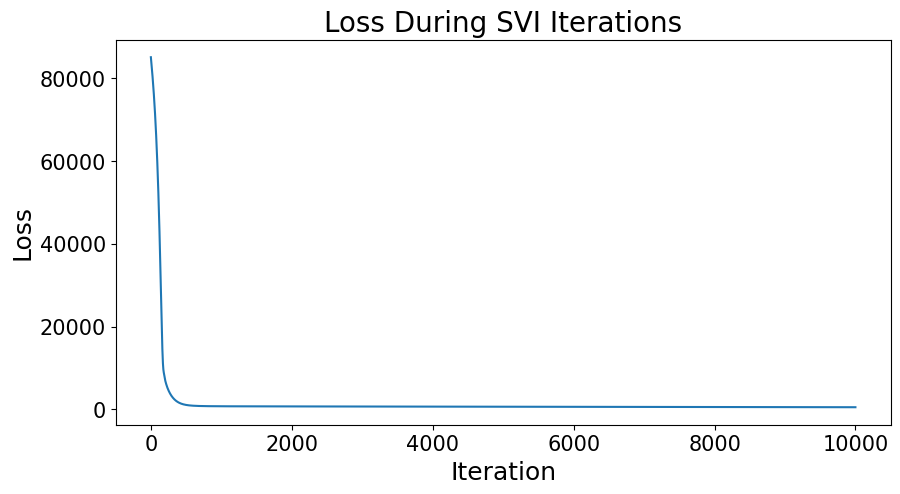

In [10]:
import matplotlib.pyplot as plt

# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("Loss During SVI Iterations", fontsize = 20)
plt.xlabel("Iteration", fontsize = 18)
plt.ylabel("Loss", fontsize = 18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

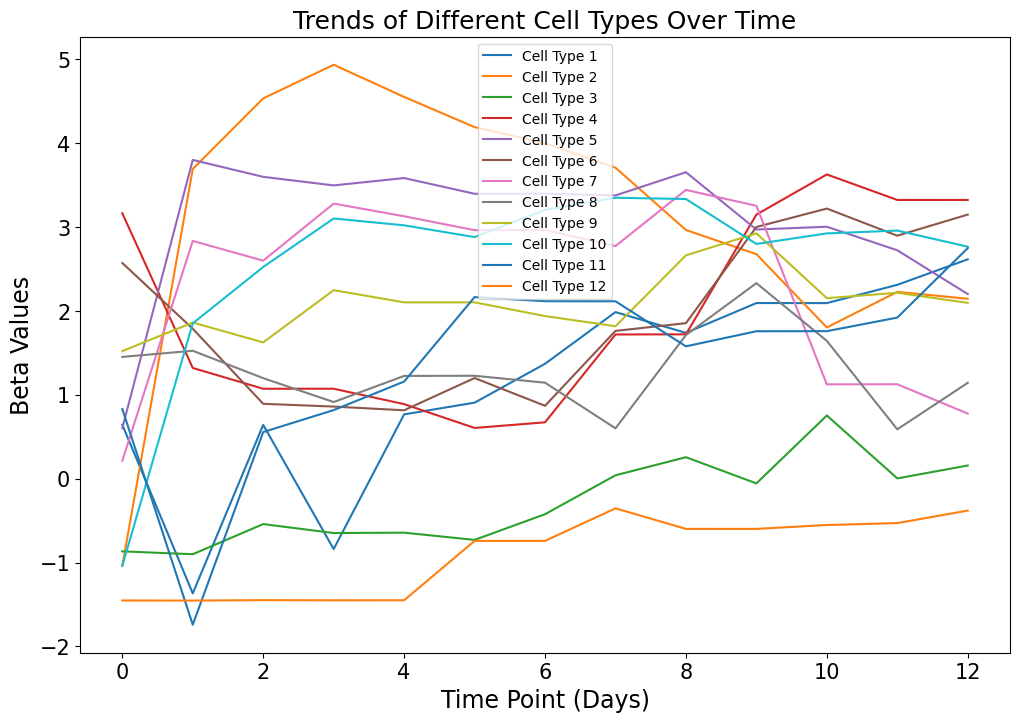

Learned Beta Values:
[[ 6.4409071e-01 -1.0395916e+00 -8.6692679e-01  3.1657743e+00
   6.0264480e-01  2.5727296e+00  2.1310484e-01  1.4524657e+00
   1.5210994e+00 -1.0395917e+00  8.3170533e-01 -1.4528311e+00]
 [-1.3679800e+00  3.6932042e+00 -9.0098995e-01  1.3204030e+00
   3.8017397e+00  1.7880141e+00  2.8356938e+00  1.5255055e+00
   1.8622563e+00  1.8525782e+00 -1.7418138e+00 -1.4538542e+00]
 [ 6.4169079e-01  4.5353727e+00 -5.4153889e-01  1.0724884e+00
   3.5998187e+00  8.9300573e-01  2.6002541e+00  1.1987574e+00
   1.6255311e+00  2.5247538e+00  5.5598670e-01 -1.4485356e+00]
 [-8.3947319e-01  4.9371209e+00 -6.4823890e-01  1.0729668e+00
   3.4977992e+00  8.5987514e-01  3.2809496e+00  9.1412610e-01
   2.2480071e+00  3.1030519e+00  8.1801480e-01 -1.4503340e+00]
 [ 7.6687855e-01  4.5532255e+00 -6.4396209e-01  8.8912129e-01
   3.5853548e+00  8.1572306e-01  3.1298392e+00  1.2255235e+00
   2.1030021e+00  3.0216615e+00  1.1581542e+00 -1.4499247e+00]
 [ 9.0648550e-01  4.1929612e+00 -7.3003221e-

In [11]:
# Extract learned parameters
learned_B_0 = pyro.param("B_0").detach().numpy()
learned_Beta = pyro.param("Beta").detach().numpy()

# Plotting trends for each cell type
plt.figure(figsize=(12, 8))
for k in range(num_cell_types):
    plt.plot(range(num_time_points), learned_Beta[:, k], label=f'Cell Type {k+1}')

plt.xlabel('Time Point (Days)', fontsize = 17)
plt.ylabel('Beta Values', fontsize = 17)
plt.title('Trends of Different Cell Types Over Time', fontsize = 18)
plt.legend()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# Printing Beta values
print("Learned Beta Values:")
print(learned_Beta)

In [8]:
import numpy as np
import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt

/home/lufesu/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


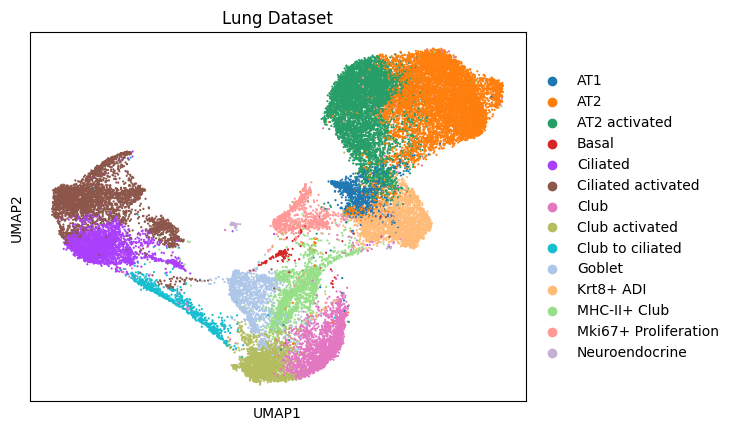

In [37]:
sc.pl.umap(adata, color='cell_type', s = 10, add_outline = False, title = 'Lung Dataset')


In [39]:
#adata_pancreatic = sc.read_text('GSE181276_genes.counts_for_GEO_uploading.txt')

In [47]:
#import anndata

#adata2 = anndata.AnnData(adata_pancreatic.to_df().values.T)
#adata2.obs_names = adata_pancreatic.var_names
#adata2.var_names = adata_pancreatic.obs_names

In [61]:
#adata2.obs = pd.DataFrame({ 'Barcode': [i.split('_')[-1] for i in cells],#    'Type' : [i.split('_')[0] for i in cells] })

In [106]:
#adata2.obs['Type'] =adata2.obs['Type'].astype('str')
#adata2.obs.loc[adata2.obs['Type'] == 'WT', 'Type'] = 'Control'
#from pandas.api.types import CategoricalDtype
#cat_type = CategoricalDtype(categories=['Control', 'D1', 'D7', 'D28'], ordered=True)
#adata2.obs['Type'] = adata2.obs['Type'].astype(cat_type)

In [121]:
#adata2 = sc.read_h5ad('raw_pancreatic.h5')